In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
data = pd.read_csv('D:/A-bus/bus_pytorch/data/data_toyset.csv')
data = data.sort_values(by=['global_order','date'])
data

,station_order,global_order,timestamp,route_info,route_id,type,date
950,1,1,22405.0,1/00740,00740,1,1
951,2,1,22556.0,1/00740,00740,1,1
952,3,1,22622.0,1/00740,00740,1,1
953,4,1,22707.0,1/00740,00740,1,1
954,5,1,22787.0,1/00740,00740,1,1
...,...,...,...,...,...,...,...
356065,26,130,71193.0,2/00740,00740,2,30
356066,27,130,71456.0,2/00740,00740,2,30
356067,28,130,71677.0,2/00740,00740,2,30
356068,29,130,72038.0,2/00740,00740,2,30


In [3]:
### shuffle index of origin data, len=434
data = data.groupby(['global_order','route_info'],as_index=False)['timestamp'].agg({'timestamp': lambda x:x.tolist()})
data = data.loc[data.route_info=='1/00740']
data = shuffle(data)
data = data.reset_index(drop=True)
data

,global_order,route_info,timestamp
0,77,1/00740,"[46895.0, 47458.0, 47517.0, 47573.0, 47650.0, ..."
1,52,1/00740,"[37664.0, 38095.0, 38176.0, 38244.0, 38340.0, ..."
2,18,1/00740,"[26834.0, 26974.0, 27062.0, 27103.0, 27555.0, ..."
3,50,1/00740,"[36885.0, 37357.0, 37425.0, 37484.0, 37579.0, ..."
4,29,1/00740,"[29573.0, 29703.0, 30070.0, 30294.0, 30466.0, ..."
...,...,...,...
105,27,1/00740,"[29093.0, 29235.0, 29383.0, 29531.0, 29887.0, ..."
106,8,1/00740,"[24419.0, 24545.0, 24614.0, 24666.0, 24778.0, ..."
107,72,1/00740,"[45293.0, 45808.0, 45870.0, 45920.0, 45995.0, ..."
108,12,1/00740,"[25244.0, 25410.0, 25581.0, 25631.0, 25723.0, ..."


In [4]:
###  train:344   val:86+3   test:1 bz=16
###  train:90   val:15   test:5 bz=15
saveTrain = 'D:/A-bus/bus_pytorch/data/dataset/partial-prediction/train.txt'
data_train = data.loc[:90,'timestamp'].reset_index(drop=True)
saveFile = open(saveTrain,'a')
for i in range(len(data_train)):
    lineToWrite = data_train[i]
    saveFile.write(f"{lineToWrite}\n")
saveFile.close()

saveVal = 'D:/A-bus/bus_pytorch/data/dataset/partial-prediction/val.txt'
data_val = data.loc[90:105,'timestamp'].reset_index(drop=True)
saveFile = open(saveVal,'a')
for i in range(len(data_val)):
    lineToWrite = data_val[i]
    saveFile.write(f"{lineToWrite}\n")
saveFile.close()

saveTest = 'D:/A-bus/bus_pytorch/data/dataset/partial-prediction/test.txt'
data_test = data.loc[105:,'timestamp'].reset_index(drop=True)
saveFile = open(saveTest,'a')
for i in range(len(data_test)):
    lineToWrite = data_test[i]
    saveFile.write(f"{lineToWrite}\n")
saveFile.close()

In [90]:
##### make KNN-dataset
##### time begins with 0
##### add lat and lon, helping to interpolate

data_ = data.copy()
data_ = data_.loc[data_.route_info=='1/00740',:]
data_ = data_.reset_index(drop=True)
# ### add trip_num, helping to group same trip
station_diff = np.where(np.diff(data_['station_order'])==-37)[0]+1
a = np.array([i+1 for i in range(len(station_diff)+1)])
data_['trip_num'] = np.repeat(a,38)
# ### make time of trip is relative to the first station
data_ = data_.groupby(['trip_num'],as_index=False)['timestamp'].agg({'timestamp': lambda x:x.tolist()})
data_.timestamp = data_.timestamp.apply(lambda x: [i-x[0] for i in x])
data_

,trip_num,timestamp
0,1,"[0.0, 151.0, 217.0, 302.0, 382.0, 648.0, 754.0..."
1,2,"[0.0, 133.0, 204.0, 293.0, 383.0, 733.0, 861.0..."
2,3,"[0.0, 184.0, 249.0, 318.0, 402.0, 665.0, 778.0..."
3,4,"[0.0, 180.0, 246.0, 320.0, 406.0, 686.0, 812.0..."
4,5,"[0.0, 133.0, 203.0, 269.0, 352.0, 656.0, 792.0..."
...,...,...
3295,3296,"[0.0, 487.0, 573.0, 635.0, 711.0, 907.0, 1104...."
3296,3297,"[0.0, 537.0, 625.0, 689.0, 795.0, 1097.0, 1200..."
3297,3298,"[0.0, 295.0, 374.0, 439.0, 534.0, 902.0, 1037...."
3298,3299,"[0.0, 211.0, 310.0, 413.0, 479.0, 736.0, 837.0..."


In [120]:
### interpolate 10m
l = [380,
 200,
 280,
 470,
 2890,
 780,
 750,
 560,
 560,
 320,
 280,
 240,
 1460,
 460,
 690,
 380,
 570,
 320,
 360,
 620,
 440,
 510,
 1330,
 1270,
 1320,
 550,
 350,
 380,
 410,
 340,
 640,
 220,
 360,
 410,
 780,
 140,
 70]
l = [380,
 200,
 280,
 470,
 2890,
 780,
 750,
 560,
 560,
 320,
 280,
 240,
 1460,
 460,
 690,
 380,
 570,
 320,
 360,
 620,
 440,
 510,
 1330,
 1270,
 1320,
 550,
 350,
 380,
 410,
 340,
 640,
 220,
 360,
 410,
 780,
 140,
 70]
l = [int(i/10) for i in l]
l = np.cumsum(l)   # test: l[2:]
time = data_.timestamp[0]
l

array([  38,   58,   86,  133,  422,  500,  575,  631,  687,  719,  747,
        771,  917,  963, 1032, 1070, 1127, 1159, 1195, 1257, 1301, 1352,
       1485, 1612, 1744, 1799, 1834, 1872, 1913, 1947, 2011, 2033, 2069,
       2110, 2188, 2202, 2209])

In [128]:
def func(time):
 time_array = np.linspace(time[0],time[1],5)
 distance_array = np.linspace(0,l[0],5)
 for i in range(1,len(l)):
   index = np.linspace(time[i],time[i+1],5)
   time_array = np.concatenate((time_array,index[1:]))
   index = np.linspace(l[i-1],l[i],5)
   distance_array = np.concatenate((distance_array,index[1:]))
 coord = []
 for a, b in zip(distance_array,time_array):
     coord.append( [ a, b ] )
 return coord

# time_array = np.linspace(time[0],time[1],5)
# distance_array = np.linspace(0,l[0],5)
# time_array, distance_array
# for i in range(1,len(l)):
#   index = np.linspace(time[i],time[i+1],5)
#   time_array = np.concatenate((time_array,index[1:]))
#   index = np.linspace(l[i-1],l[i],5)
#   distance_array = np.concatenate((distance_array,index[1:]))
# coord = []
# for a, b in zip(distance_array,time_array):
#     coord.append( [ a, b ] )
# [coord[i] for i in range(0,150) if i%4==0]  # 每个站点之间插3个点

In [129]:
data_['coord'] = data_['timestamp'].apply(lambda x: func(x))

In [131]:
###'1/00740'  totoal:3300
saveTrain = 'D:/A-bus/bus_pytorch/data/dataset/knn-dataset/train.csv'
data_train = data_['coord'].reset_index(drop=True)
pd.DataFrame(data_train).to_csv(saveTrain,index=False)

In [81]:
filename = 'D:/A-bus/bus_pytorch/data/dataset/knn-dataset/train.txt'
import json
with open(filename, 'r') as f:
    data = f.readlines()
np.array(json.loads(data))

TypeError: the JSON object must be str, bytes or bytearray, not list

In [19]:
import torch
A1,A2,A3 = 60 * torch.rand(3,4500)

In [23]:
A4 = torch.max(A1, A2)
A4.shape

torch.Size([4500])

In [25]:
t0 = 96
mask = torch.zeros(t0+24,t0+24)
for i in range(0,t0):
    mask[i,t0:] = 1
for i in range(t0,t0+24):
    mask[i,i+1:] = 1
mask = mask.float().masked_fill(mask == 1, float('-inf'))#.masked_fill(mask == 1, float(0.0))
mask

tensor([[0., 0., 0.,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [29]:
x = torch.cat(4500*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])
x.shape

torch.Size([4500, 120])

In [31]:
fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*x[0,0:12]/6)+72 ,
                        A2.unsqueeze(1)*torch.sin(np.pi*x[0,12:24]/6)+72 ,
                        A3.unsqueeze(1)*torch.sin(np.pi*x[0,24:t0]/6)+72,
                        A4.unsqueeze(1)*torch.sin(np.pi*x[0,t0:t0+24]/12)+72],1)
fx.shape

torch.Size([4500, 120])

In [30]:
(A1.unsqueeze(1)*torch.sin(np.pi*x[0,0:12]/6)+72).shape

torch.Size([4500, 12])

In [8]:
# POS EMBEDDING
# 1. no period
d_model = 128
import torch
PE = torch.zeros((29, d_model))  # [29, 128]
pos = torch.arange(29).unsqueeze(1)
PE[:, 0::2] = torch.sin(pos/torch.pow(1000, torch.arange(0, d_model, 2)/d_model))
PE[:, 1::2] = torch.sin(pos/torch.pow(1000, torch.arange(1, d_model, 2)/d_model))

torch.Size([29, 1])

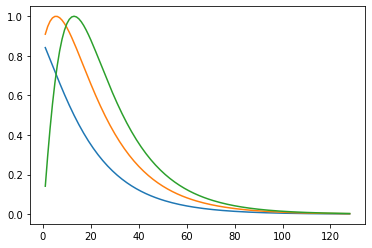

In [23]:
plt.plot(list(range(1,129)),PE[1,:])
plt.plot(list(range(1,129)),PE[2,:])
plt.plot(list(range(1,129)),PE[3,:])

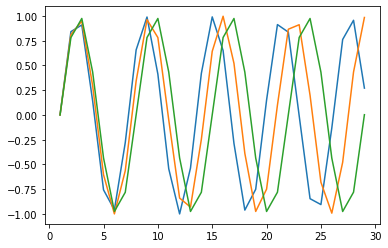

In [26]:
plt.plot(list(range(1,30)),PE[:,0])
plt.plot(list(range(1,30)),PE[:,1])
plt.plot(list(range(1,30)),PE[:,2])

In [35]:
# 3. period
d_model = 128
period = 7
PE = torch.zeros((29, d_model))  # [29, 128]
pos = torch.arange(29).unsqueeze(1) # [29, 1]
PE = torch.sin(pos * 2 * np.pi / period)
print(PE.shape)
PE = PE.repeat((1, d_model))
print(PE.shape)

torch.Size([29, 1])
torch.Size([29, 128])


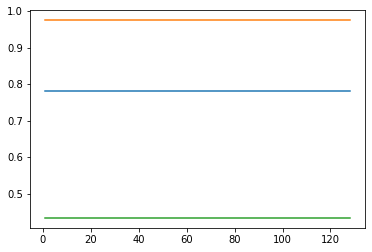

In [37]:
plt.plot(list(range(1,129)),PE[1,:])
plt.plot(list(range(1,129)),PE[2,:])
plt.plot(list(range(1,129)),PE[3,:])

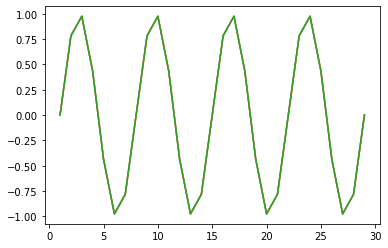

In [40]:
plt.plot(list(range(1,30)),PE[:,0])
plt.plot(list(range(1,30)),PE[:,1])
plt.plot(list(range(1,30)),PE[:,2])

In [71]:
#### convolutional attention
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)

        self.__padding = (kernel_size - 1) * dilation

    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))

In [72]:
kernel_size = 3
in_channels=1
out_channels=1
dilation = 1
x = torch.randint(1,10,(1,20)).type(torch.float)
convlayer = CausalConv1d(in_channels,out_channels,kernel_size,dilation=dilation)
print(convlayer(x.unsqueeze(0)).shape)
print(convlayer(x.unsqueeze(0)))

torch.Size([1, 1, 20])
tensor([[[-1.6832, -4.9013, -6.0907, -3.7566, -2.4711, -2.5708, -3.8122,
          -4.8550, -5.6173, -3.7324, -4.0656, -5.2786, -6.4146, -4.5795,
          -3.3794, -3.6677, -4.7959, -4.9867, -4.7589, -5.1568]]],
       grad_fn=<ConvolutionBackward0>)


In [64]:
__padding = (kernel_size - 1) * dilation
x_pad = F.pad(x, (__padding, 0))
torch.dot(convlayer.weight[0][0],x_pad[0][0:3])+convlayer.bias[0]

tensor(0.9517, grad_fn=<AddBackward0>)

In [68]:
class context_embedding(torch.nn.Module):
    def __init__(self, in_channels=1,embedding_size=256,k=5):
        super(context_embedding,self).__init__()
        self.causal_convolution = CausalConv1d(in_channels,embedding_size,kernel_size=k)

    def forward(self, x):
        x = self.causal_convolution(x)
        return F.sigmoid(x)
embedding = context_embedding(1,256,5)
embedding(x.unsqueeze(0)).shape

F:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1, 256, 20])